In [1]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Download model
!gdown --id 1QWPRnL02rOgm6xZmcmfyWVuVubKeYry4
!unzip -qq colorize.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QWPRnL02rOgm6xZmcmfyWVuVubKeYry4
To: /content/colorize.zip
100% 120M/120M [00:00<00:00, 145MB/s]


In [2]:
!mkdir Images

#Now we have made a folder in our instance, click on 3 dots on the folder and upload the grayscale images that you want to colorize
#in that folder. Then run the following code block.

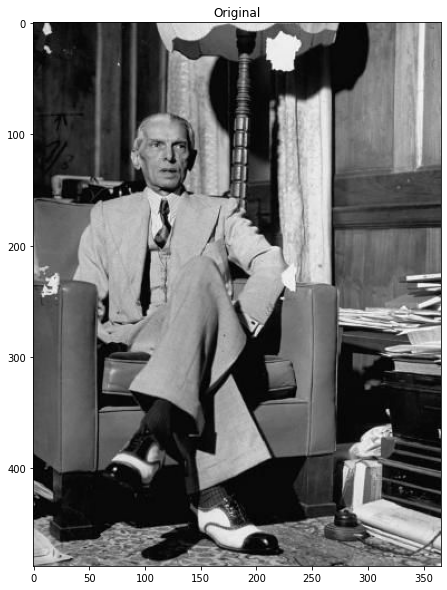

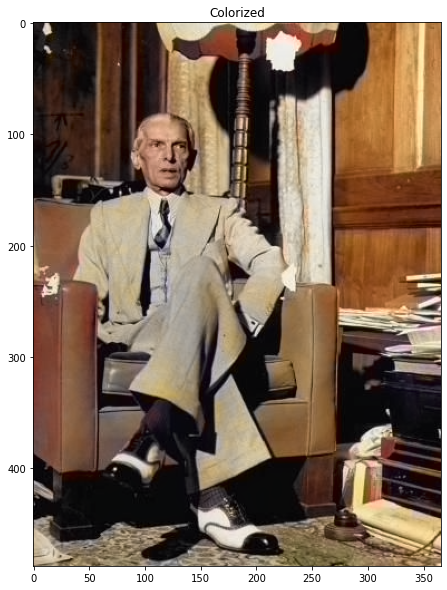

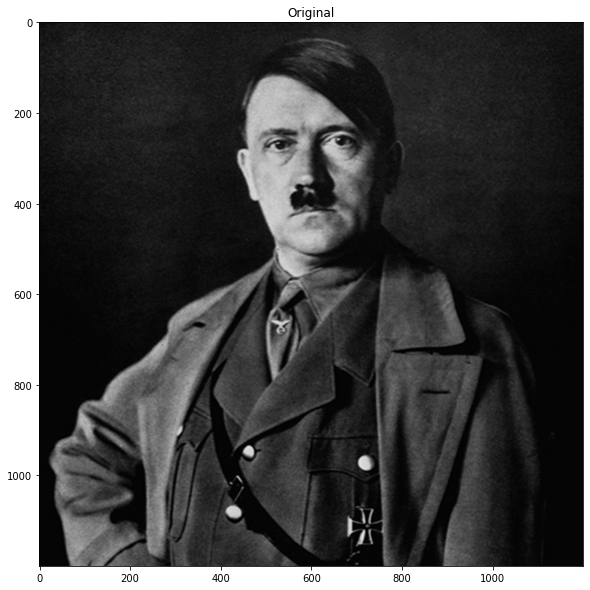

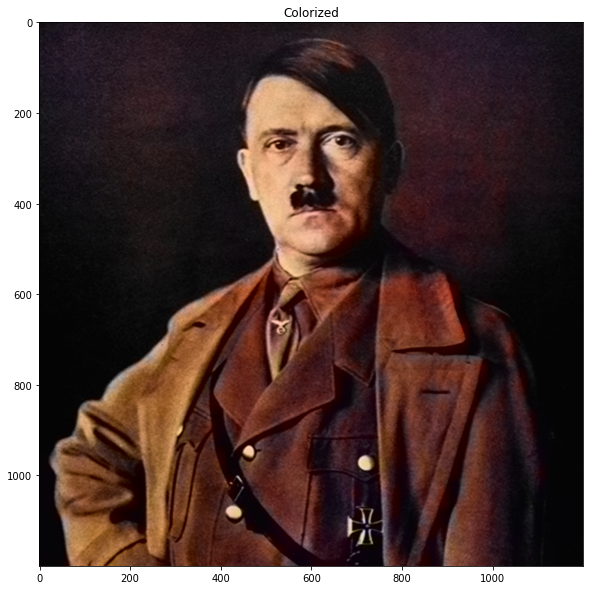

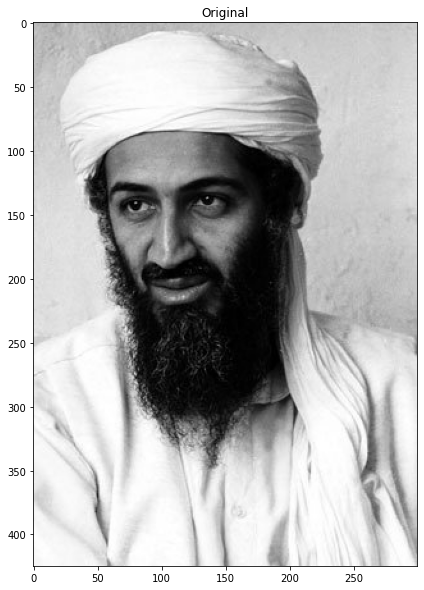

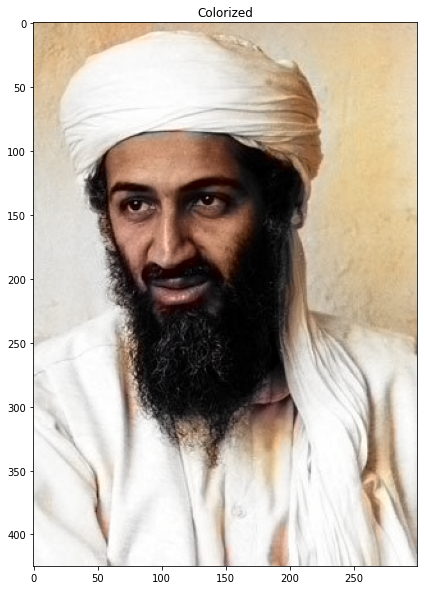

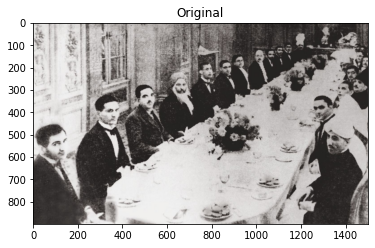

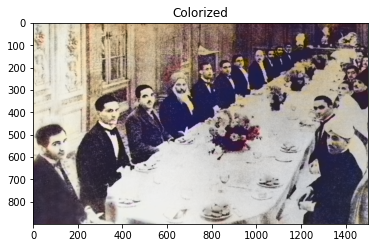

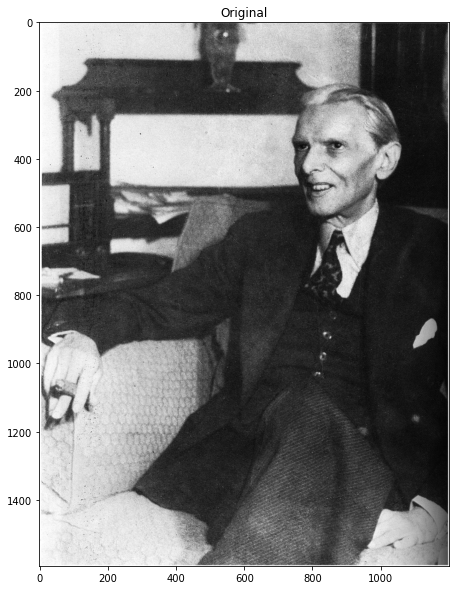

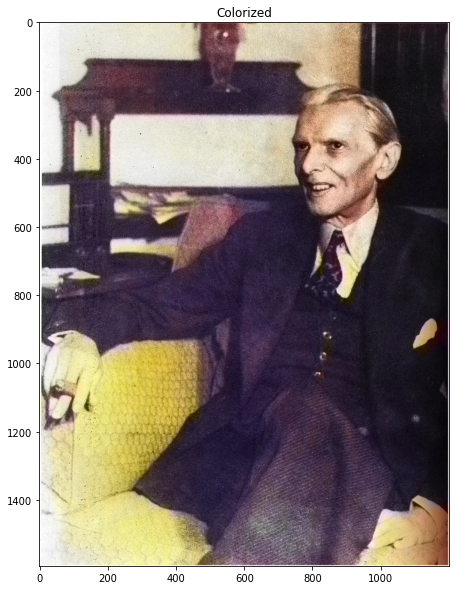

In [3]:
# Get our images
file_path = "Images/"
blackandwhite_imgs = [f for f in listdir(file_path) if isfile(join(file_path, f))]
kernel = 'colorize/pts_in_hull.npy'

# Start the main program
if __name__ == '__main__':

    # Select desired model
    net = cv2.dnn.readNetFromCaffe("colorize/colorization_deploy_v2.prototxt",
                               "colorize/colorization_release_v2.caffemodel")

    # load cluster centers
    pts_in_hull = np.load(kernel) 

    # populate cluster centers as 1x1 convolution kernel
    pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1)
    net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull.astype(np.float32)]
    net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

    for image in blackandwhite_imgs:
        img = cv2.imread(file_path+image)
        
        img_rgb = (img[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)
        img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
        
        # pull out L channel
        img_l = img_lab[:,:,0]
        
        # get original image size
        (H_orig,W_orig) = img_rgb.shape[:2] 

        # resize image to network input size
        img_rs = cv2.resize(img_rgb, (224, 224)) 
        
        # resize image to network input size
        img_lab_rs = cv2.cvtColor(img_rs, cv2.COLOR_RGB2Lab)
        img_l_rs = img_lab_rs[:,:,0]
        
        # subtract 50 for mean-centering
        img_l_rs -= 50 

        net.setInput(cv2.dnn.blobFromImage(img_l_rs))
        
        # this is our result
        ab_dec = net.forward('class8_ab')[0,:,:,:].transpose((1,2,0)) 

        (H_out,W_out) = ab_dec.shape[:2]
        ab_dec_us = cv2.resize(ab_dec, (W_orig, H_orig))
        img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) 
        
        # concatenate with original image L
        img_bgr_out = np.clip(cv2.cvtColor(img_lab_out, cv2.COLOR_Lab2BGR), 0, 1)

        # show original image
        imshow('Original', img)
        # Resize the corlized image to it's orginal dimensions 
        img_bgr_out = cv2.resize(img_bgr_out, (W_orig, H_orig), interpolation = cv2.INTER_AREA)
        imshow('Colorized', img_bgr_out)